# Doing Region Segmentation Using Traditional Techniques

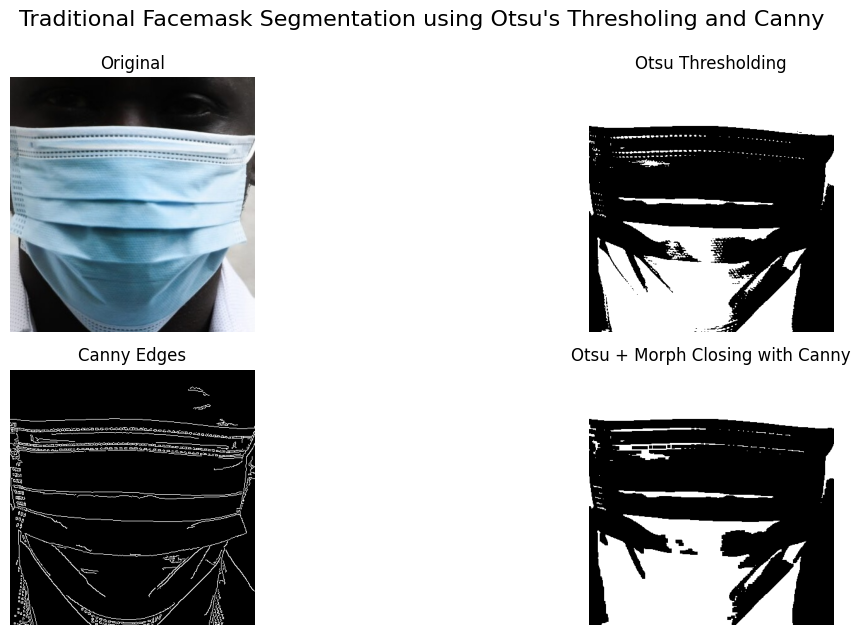

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and preprocess image
img_path = 'MSFD/1/face_crop/000000_1.jpg'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Otsu Thresholding (Segment dark regions)
_, otsu_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Canny Edge Detection (Find edges of mask)
edges = cv2.Canny(gray, 50, 150)

# Morphological Closing to fill mask regions
kernel = np.ones((5, 5), np.uint8)
otsu_closed = cv2.morphologyEx(otsu_mask, cv2.MORPH_CLOSE, kernel)

# Combine Otsu and Canny to build a refined mask
combined = cv2.bitwise_and(otsu_closed, otsu_closed, mask=edges)


# Visualizing everything
plt.figure(figsize=(15, 6))

plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(otsu_mask, cmap='gray')
plt.title("Otsu Thresholding")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(otsu_closed, cmap='gray')
plt.title("Otsu + Morph Closing with Canny")
plt.axis('off')


plt.tight_layout()
plt.suptitle("Traditional Facemask Segmentation using Otsu's Thresholing and Canny", fontsize=16, y=1.05)
plt.show()


We now use these techniques on each of the images and find the average IOU and Dice.

In [ ]:
import os

# Paths
image_dir = 'MSFD/1/face_crop'
mask_dir = 'MSFD/1/face_crop_segmentation'

# Kernel for morphological closing
kernel = np.ones((5, 5), np.uint8)

# Store metrics
ious_otsu, dices_otsu = [], []
ious_canny, dices_canny = [], []
ious_combined, dices_combined = [], []

image_files = sorted(os.listdir(image_dir))

for filename in image_files:
    img_path = os.path.join(image_dir, filename)
    mask_path = os.path.join(mask_dir, filename)

    img = cv2.imread(img_path)
    gt = cv2.imread(mask_path, 0)

    if img is None or gt is None:
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gt_mask = (gt > 127).astype(np.uint8)

    # 1. Otsu Thresholding
    _, otsu_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    otsu_closed = cv2.morphologyEx(otsu_mask, cv2.MORPH_CLOSE, kernel)
    pred_otsu = (otsu_closed > 0).astype(np.uint8)

    # 2. Canny Edges
    edges = cv2.Canny(gray, 50, 150)
    pred_canny = (edges > 0).astype(np.uint8)

    # 3. Combined (Otsu ∩ Canny)
    combined = cv2.bitwise_and(otsu_closed, otsu_closed, mask=edges)
    pred_combined = (combined > 0).astype(np.uint8)

    # Metric function
    def compute_metrics(pred, gt):
        intersection = np.logical_and(pred, gt).sum()
        union = np.logical_or(pred, gt).sum()
        iou = intersection / (union + 1e-6)
        dice = 2 * intersection / (pred.sum() + gt.sum() + 1e-6)
        return iou, dice

    # Resize predictions to match ground truth shape
    pred_otsu = cv2.resize(pred_otsu, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    pred_canny = cv2.resize(pred_canny, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    pred_combined = cv2.resize(pred_combined, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    
    # Compute and store
    iou, dice = compute_metrics(pred_otsu, gt_mask)
    ious_otsu.append(iou)
    dices_otsu.append(dice)

    iou, dice = compute_metrics(pred_canny, gt_mask)
    ious_canny.append(iou)
    dices_canny.append(dice)

    iou, dice = compute_metrics(pred_combined, gt_mask)
    ious_combined.append(iou)
    dices_combined.append(dice)

# Final average scores
print(f"Evaluated {len(ious_otsu)} images\n")

print(f"Otsu Thresholding:")
print(f"  Average IoU: {np.mean(ious_otsu):.4f}")
print(f"  Average Dice: {np.mean(dices_otsu):.4f}\n")

print(f"Canny Edge Detection:")
print(f"  Average IoU: {np.mean(ious_canny):.4f}")
print(f"  Average Dice: {np.mean(dices_canny):.4f}\n")

print(f"Otsu and Canny (Combined):")
print(f"  Average IoU: {np.mean(ious_combined):.4f}")
print(f"  Average Dice: {np.mean(dices_combined):.4f}")


Evaluated 9382 images

Otsu Thresholding:
  Average IoU: 0.2583
  Average Dice: 0.3603

Canny Edge Detection:
  Average IoU: 0.1049
  Average Dice: 0.1828

Otsu and Canny (Combined):
  Average IoU: 0.0606
  Average Dice: 0.1078


Till now we have done segmentation using Otsu and Canny and found the mean IOU and Dice score across all images.Now we move onto use UNET

In [ ]:
cv2.imread('MSFD/1/face_crop/000003_1.jpg').shape

(675, 476, 3)

# Using U-Net

Checked manually that the images seem to have a size of greater than 256*256.Therefore we use that as the input size for unet

In [26]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Config
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 16

In [ ]:
# Paths
BASE_DIR = "MSFD/1"
IMAGE_DIR = os.path.join(BASE_DIR, "face_crop")
MASK_DIR = os.path.join(BASE_DIR, "face_crop_segmentation")

# Load file paths
image_paths = sorted([os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)])
mask_paths = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR)])

# Train-test split
train_imgs, valtest_imgs, train_masks, valtest_masks = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(valtest_imgs, valtest_masks, test_size=0.5, random_state=42)


In [34]:
# Image-mask loader
def parse_img_mask(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.cast(mask > 127, tf.float32)

    return img, mask

# Dataset builder
def create_dataset(imgs, masks):
    ds = tf.data.Dataset.from_tensor_slices((imgs, masks))
    ds = ds.map(parse_img_mask, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [35]:
train_ds = create_dataset(train_imgs, train_masks)
val_ds = create_dataset(val_imgs, val_masks)
test_ds = create_dataset(test_imgs, test_masks)

In [36]:
# We have used the standard UNEt architecture as discussed in the orginal Research Paper alongwith 1 modification:
# We have aso added a Batch Normalization after each convolution layer to increase stability and training speed.
import tensorflow as tf
from tensorflow.keras import layers, models

# The Convolution Block
def conv_block(inputs, filters, batch_norm=True):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def unet_model(input_size=(256, 256, 1), batch_norm=True):
    inputs = tf.keras.Input(input_size)

    # Contracting Path
    c1 = conv_block(inputs, 64, batch_norm)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, 128, batch_norm)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, 256, batch_norm)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = conv_block(p3, 512, batch_norm)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 1024, batch_norm)

    # Expansive Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.Concatenate()([u6, c4])
    c6 = conv_block(u6, 512, batch_norm)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = conv_block(u7, 256, batch_norm)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = conv_block(u8, 128, batch_norm)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = conv_block(u9, 64, batch_norm)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return models.Model(inputs, outputs)


# Metrics
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-7):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)


In [37]:
model = unet_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_64    │ (None, 256, 256, 64)   │            256 │ conv2d_67[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_64 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ re_lu_64[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_65    │ (None, 256, 256, 64)   │            256 │ conv2d_68[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_65 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 128, 128, 64)   │              0 │ re_lu_65[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_66    │ (None, 128, 128, 128)  │            512 │ conv2d_69[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_66 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ re_lu_66[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_67    │ (None, 128, 128, 128)  │            512 │ conv2d_70[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_67 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 64, 64, 128)    │              0 │ re_lu_67[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_17[0][0] │
├──────────────────────

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [44]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[dice_coef, iou_metric])

model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 189s 417ms/step - dice_coef: 0.8276 - iou_metric: 0.7064 - loss: 0.2543 - val_dice_coef: 0.7847 - val_iou_metric: 0.6465 - val_loss: 0.3100
Epoch 2/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 162s 395ms/step - dice_coef: 0.8326 - iou_metric: 0.7137 - loss: 0.2478 - val_dice_coef: 0.7789 - val_iou_metric: 0.6387 - val_loss: 0.3164
Epoch 3/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 162s 395ms/step - dice_coef: 0.8380 - iou_metric: 0.7216 - loss: 0.2402 - val_dice_coef: 0.7612 - val_iou_metric: 0.6153 - val_loss: 0.3425
Epoch 4/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 162s 395ms/step - dice_coef: 0.8429 - iou_metric: 0.7289 - loss: 0.2333 - val_dice_coef: 0.6955 - val_iou_metric: 0.5343 - val_loss: 0.4442
Epoch 5/5
411/411 ━━━━━━━━━━━━━━━━━━━━ 162s 395ms/step - dice_coef: 0.8479 - iou_metric: 0.7364 - loss: 0.2260 - val_dice_coef: 0.7629 - val_iou_metric: 0.6176 - val_loss: 0.3412


In [45]:
# Final Evaluation
print("\nTesting Metrics:")
val_metrics = model.evaluate(test_ds)
print(f"Dice Score: {val_metrics[1]:.4f}")
print(f"IoU Score:  {val_metrics[2]:.4f}")


Testing Metrics:
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - dice_coef: 0.7636 - iou_metric: 0.6182 - loss: 0.3428
Dice Score: 0.7604
IoU Score:  0.6142


# Comparing the results

In [46]:
import pandas as pd
data = {
    "Method": ["Otsu Thresholding", "Canny Edge Detection", "Otsu and Canny (Combined)", "U-Net"],
    "Average IoU": [
        np.mean(ious_otsu),
        np.mean(ious_canny),
        np.mean(ious_combined),
        np.mean(val_metrics[2])
    ],
    "Average Dice": [
        np.mean(dices_otsu),
        np.mean(dices_canny),
        np.mean(dices_combined),
        np.mean(val_metrics[1])
    ]
}

df = pd.DataFrame(data)
df

,Method,Average IoU,Average Dice
0,Otsu Thresholding,0.258274,0.360258
1,Canny Edge Detection,0.104900,0.182770
2,Otsu and Canny (Combined),0.060586,0.107802
3,U-Net,0.614172,0.760439


Over here we can clearly see the **UNET outperforms** the other tradional methods by a huge margin.

1. If we sit and tune the parameters in the traditional methods for each image then the scores might get better for the traditional methods as well but when dealing with a huge amount of data that is not possible."
2. Therefore UNET is used.